<a href="https://colab.research.google.com/github/iRahulPandey/medium-articles/blob/master/DataVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Visualization

The notebook shows various ways of visualizing amazing data
- Matplotlib
- Seaborn
- Plotly Express
- bqplot
- altair
- bokeh

## Import libraries

In [1]:
# install
!pip install colorama
!pip install pycountry
!pip install pycountry-convert
!pip install oscovida
!pip install --upgrade plotly
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from plotly.colors import n_colors
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import missingno as msno
from datetime import date, datetime, timedelta
from colorama import Fore, Back, Style
import pycountry
import pycountry_convert as pc
import oscovida as ov
import folium
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

     |████████████████████████████████| 13.2MB 7.5MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


## Get Data

In [2]:
# get the previous day to fetch data from for latest data and us_medical_data
today = date.today()
latest_data = today-timedelta(days = 1)

# generate url
latest_data_url = 'https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'+latest_data.strftime("%m-%d-%Y")+'.csv'
us_medical_data_url = 'https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/'+latest_data.strftime("%m-%d-%Y")+'.csv'

In [3]:
# Get data from Center for Systems Science and Engineering (CSSE)
# https://github.com/CSSEGISandData/COVID-19
# confirmed cases
confirmed_cases = pd.read_csv('https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
# recoveries
recoveries= pd.read_csv('https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
# deaths
deaths = pd.read_csv('https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
# current data
latest_data = pd.read_csv(latest_data_url)
# us medical data
us_medical_data = pd.read_csv(us_medical_data_url)
# vaccination manufacturer
vaccine_manufacturer = pd.read_csv('https://raw.github.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations-by-manufacturer.csv')
# vaccination manufacturer
vaccine = pd.read_csv('https://raw.github.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv')
# get incidence for different countries
cases_incidence, deaths_incidence = ov.get_incidence_rates_countries()

In [4]:
# show confirmed data
confirmed_cases.head(n=2)

Province/State Country/Region       Lat  ...  5/23/21  5/24/21  5/25/21
0            NaN    Afghanistan  33.93911  ...    65728    66275    66903
1            NaN        Albania  41.15330  ...   132209   132215   132229

[2 rows x 494 columns]

## Missing Data

In [5]:
# missing data without visualization in percentage
confirmed_cases.isnull().sum()/len(confirmed_cases)*100

Province/State    68.727273
Country/Region     0.000000
Lat                0.727273
Long               0.727273
1/22/20            0.000000
                    ...    
5/21/21            0.000000
5/22/21            0.000000
5/23/21            0.000000
5/24/21            0.000000
5/25/21            0.000000
Length: 494, dtype: float64

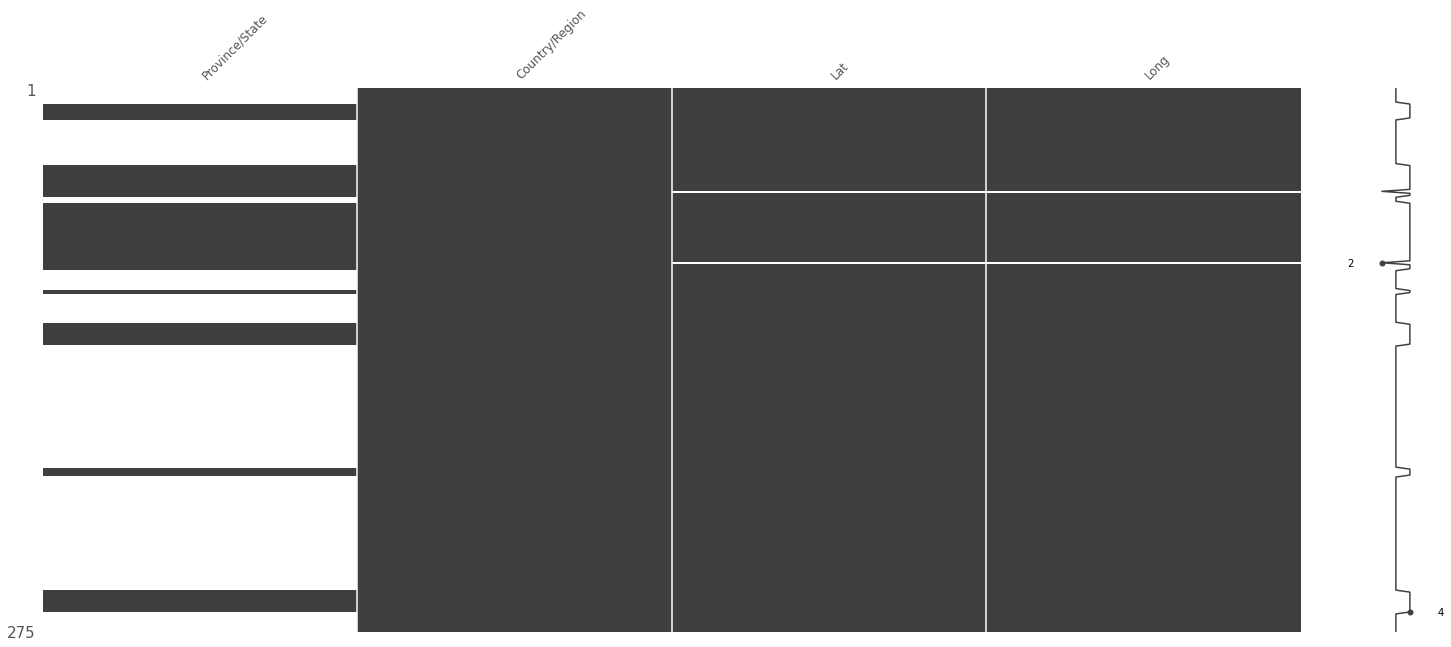

In [6]:
# list for visualization
columns = ['Province/State','Country/Region','Lat','Long']

# visualize missing data
msno.matrix(confirmed_cases[columns], fontsize=12);

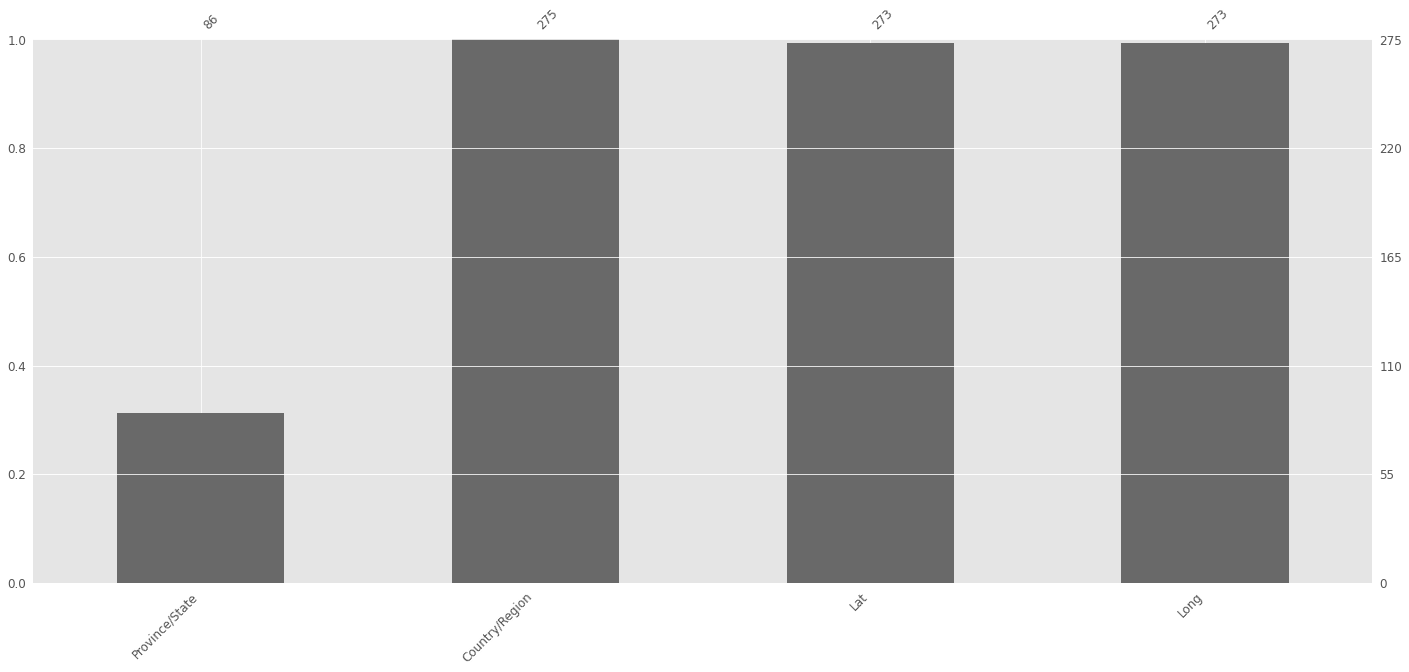

In [7]:
# visualize histogram 
msno.bar(confirmed_cases[columns], fontsize=12);

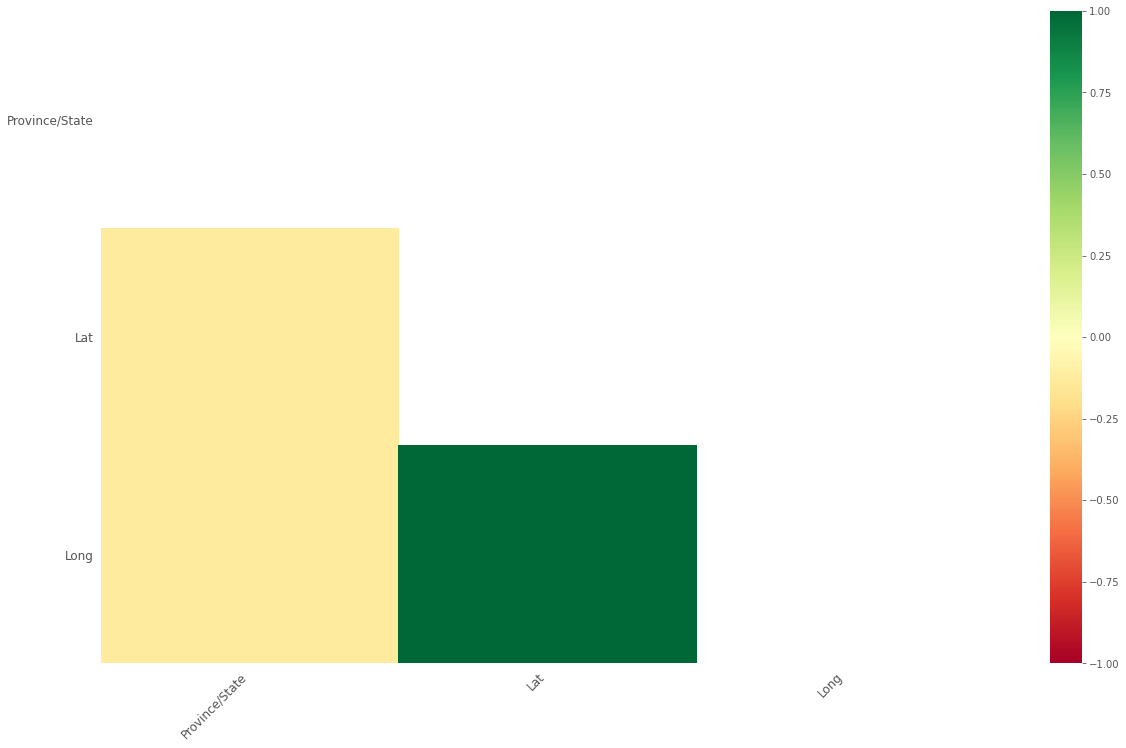

In [8]:
msno.heatmap(confirmed_cases[columns], fontsize=12, cmap="RdYlGn",labels=False);

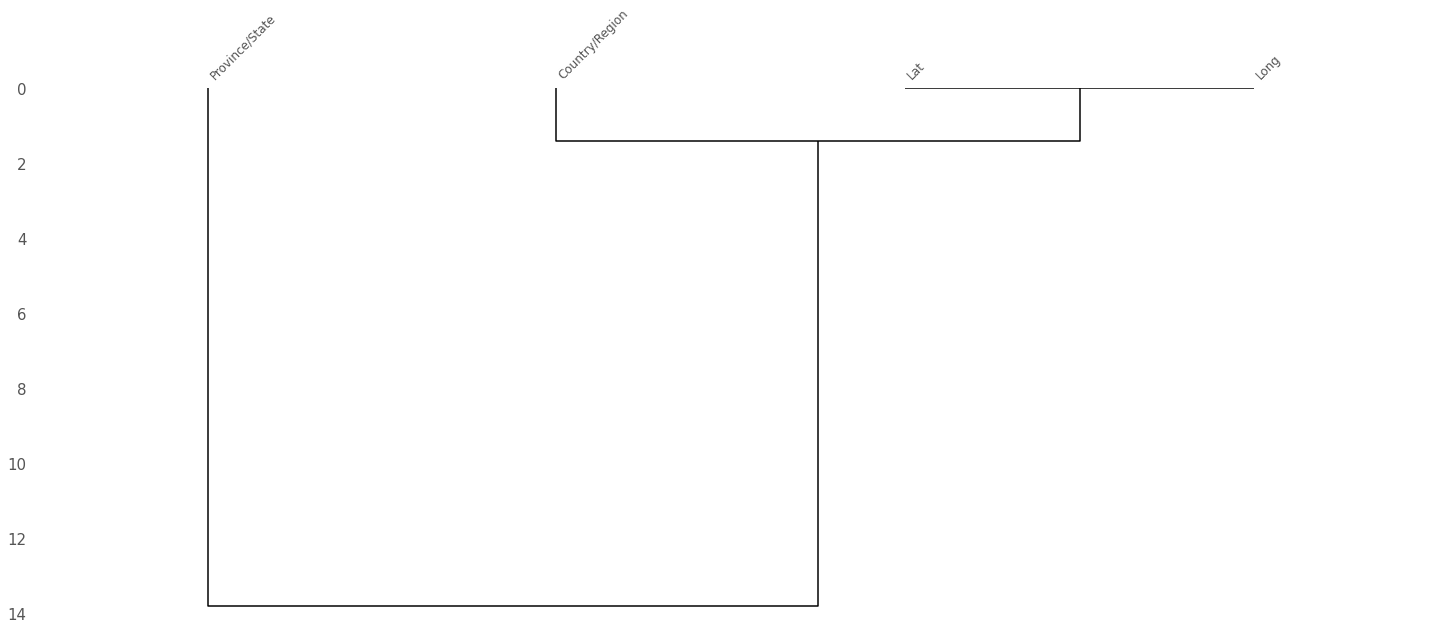

In [9]:
msno.dendrogram(confirmed_cases[columns], fontsize=12);

## Data Transformation

#### Merge Data

In [10]:
# melt data
melted_confirmed_df = confirmed_cases.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
        var_name=['Date'], 
        value_name='Confirmed_Cases')

melted_deaths_df = deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
        var_name=['Date'], 
        value_name='Deaths')

In [11]:
# get columns data
dates_columns = confirmed_cases.columns[4:]

# recovery data
melted_recoveries_df = recoveries.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                              value_vars=dates_columns, 
                              var_name='Date',
                              value_name='Recovered')

# format date
melted_recoveries_df['Date'] = pd.to_datetime(melted_recoveries_df['Date'])

# fill nan
melted_recoveries_df.fillna(0, inplace=True)

In [12]:
# combine two dataframe
df_combined = pd.concat([melted_confirmed_df, melted_deaths_df["Deaths"]], axis = 1, sort = False)

# format date
df_combined['Date'] = pd.to_datetime(df_combined['Date'])

# fill nan
df_combined.fillna(0, inplace=True)

In [13]:
# global daily data
df_global_daily = pd.DataFrame(df_combined[['Confirmed_Cases','Deaths','Date']].groupby('Date').sum()).sort_index()

In [14]:
# global daily recovery
df_global_recovery_daily = pd.DataFrame(melted_recoveries_df[['Recovered', 'Date']].groupby('Date').sum()).sort_index()

In [15]:
# countries daily data
df_countries_daily = pd.DataFrame(df_combined[['Confirmed_Cases','Deaths','Date','Country/Region']].groupby(['Date','Country/Region']).sum()).sort_index()

In [16]:
# countries daily recovery data
df_countries_recovery_daily = pd.DataFrame(melted_recoveries_df[['Recovered','Date','Country/Region']].groupby(['Date','Country/Region']).sum()).sort_index()

#### Latest data

In [17]:
# columns to use
latest_data_columns = ['Province_State',	'Country_Region', 'Lat', 'Long_', 'Confirmed',	'Deaths',	'Recovered',	'Active',	'Incident_Rate',	'Case_Fatality_Ratio']

# latest data
df_latest_data = latest_data[latest_data_columns]

# group by country
df_countries_latest= pd.DataFrame(df_latest_data[['Country_Region', 'Confirmed',	'Deaths',	'Recovered',	'Active',	'Incident_Rate']].groupby(['Country_Region']).sum()).sort_index()

#### Global Daily Data

In [18]:
# merging global daily
df_global_merged = pd.concat([df_global_daily, df_global_recovery_daily["Recovered"]], axis = 1, sort = False)

#### Global Daily Data based on countries

In [19]:
# merging countries daily
df_countries_merged = pd.concat([df_countries_daily, df_countries_recovery_daily["Recovered"]], axis = 1, sort = False)

#### Daily Vaccination

In [20]:
# columns to use
vaccine_data_columns = ['location',	'date', 'daily_vaccinations']

# vaccine data
df_vaccine_data = vaccine[vaccine_data_columns].copy()

# format date
df_vaccine_data['date'] = pd.to_datetime(df_vaccine_data['date'])

# fill nan
df_vaccine_data.fillna(0, inplace=True)

In [21]:
# total vaccination by country
df_total_vaccine_location = pd.DataFrame(df_vaccine_data[['location',	'daily_vaccinations']].groupby(['location']).sum()).sort_index()

In [22]:
df_vaccine_data

location       date  daily_vaccinations
0      Afghanistan 2021-02-22                 0.0
1      Afghanistan 2021-02-23              1367.0
2      Afghanistan 2021-02-24              1367.0
3      Afghanistan 2021-02-25              1367.0
4      Afghanistan 2021-02-26              1367.0
...            ...        ...                 ...
22092     Zimbabwe 2021-05-20             16482.0
22093     Zimbabwe 2021-05-21             16098.0
22094     Zimbabwe 2021-05-22             15823.0
22095     Zimbabwe 2021-05-23             16298.0
22096     Zimbabwe 2021-05-24             14380.0

[22097 rows x 3 columns]

### Vaccine Provider

In [23]:
# copy data
df_vaccine_manufacturer =  vaccine_manufacturer.copy()

# format date
df_vaccine_manufacturer['date'] = pd.to_datetime(df_vaccine_manufacturer['date'])

# fill nan
df_vaccine_manufacturer.fillna(0, inplace=True)

In [24]:
# daily vaccination by location
df_vaccine_location_manufacturer = pd.DataFrame(df_vaccine_manufacturer[['location',	'vaccine',	'total_vaccinations']].groupby(['location',	'vaccine']).max()).sort_index()

In [25]:
df_vaccine_location_manufacturer

total_vaccinations
location      vaccine                               
Chile         Oxford/AstraZeneca              117478
              Pfizer/BioNTech                2983372
              Sinovac                       14446792
Czechia       Johnson&Johnson                  31925
              Moderna                         453554
              Oxford/AstraZeneca              486854
              Pfizer/BioNTech                3849844
France        Johnson&Johnson                 203041
              Moderna                        3059820
              Oxford/AstraZeneca             4676487
              Pfizer/BioNTech               25153240
Germany       Johnson&Johnson                 126269
              Moderna                        3447133
              Oxford/AstraZeneca             8573988
              Pfizer/BioNTech               33252184
Iceland       Johnson&Johnson                  13244
              Moderna                          22546
              Oxford/AstraZeneca               64522
              Pfizer/BioNTech                 131328
Italy         Johnson&Johnson                 470697
              Moderna                        2783375
              Oxford/AstraZeneca             6628418
              Pfizer/BioNTech               21971741
Latvia        Johnson&Johnson                  11422
              Moderna                         134593
              Oxford/AstraZeneca              183211
              Pfizer/BioNTech                 316134
Lithuania     Johnson&Johnson                  15988
              Moderna                         139279
              Oxford/AstraZeneca              310245
              Pfizer/BioNTech                1027731
Romania       Johnson&Johnson                  71246
              Moderna                         627741
              Oxford/AstraZeneca              756116
              Pfizer/BioNTech                5922644
United States Johnson&Johnson               10381859
              Moderna                      121801185
              Pfizer/BioNTech              155394989

In [26]:
# vaccine by location
df_vaccine_location = pd.DataFrame(df_vaccine_manufacturer[df_vaccine_manufacturer['date'] == df_vaccine_manufacturer['date'].max()][['location',	'total_vaccinations']].groupby(['location']).sum()).sort_index()

In [27]:
df_vaccine_location

total_vaccinations
location                         
Czechia                   4822177
Italy                    31854231
Latvia                     645360
Lithuania                 1493243
United States           287578033

In [28]:
# Manufacturer supplying
Pfizer = df_vaccine_manufacturer[df_vaccine_manufacturer['vaccine']=='Pfizer/BioNTech'].groupby(['location']).max()['total_vaccinations'].values.sum()
Sinovac = df_vaccine_manufacturer[df_vaccine_manufacturer['vaccine']=='Sinovac'].groupby(['location']).max()['total_vaccinations'].values.sum()
AstraZeneca = df_vaccine_manufacturer[df_vaccine_manufacturer['vaccine']=='Oxford/AstraZeneca'].groupby(['location']).max()['total_vaccinations'].values.sum()
Moderna = df_vaccine_manufacturer[df_vaccine_manufacturer['vaccine']=='Moderna'].groupby(['location']).max()['total_vaccinations'].values.sum()
JohnsonJohnson = df_vaccine_manufacturer[df_vaccine_manufacturer['vaccine']=='Johnson&Johnson'].groupby(['location']).max()['total_vaccinations'].values.sum()

## Data Visualization

In [29]:
# choose color for visualization
colors_visualize = ["#009ACD","#660000","#8B008B","#b20000","#7f0000", "#04550e", "#00184c", "#dd6400", "#d2b715"]

In [30]:
# Plotting the vaccine delievery

fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Indicator(
    mode = "number",
    value = Pfizer,
    number={'font':{'color': colors_visualize[0],'size':60}},
    title = {"text": "Pfizer"},
    domain = {'x': [0.3, 0.7], 'y': [0.95, 1]}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = Moderna,
    number={'font':{'color': colors_visualize[1],'size':55}},
    title = {"text": "Moderna"},
    domain = {'x': [0.3, 0.7], 'y': [0.65, 0.75]}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = AstraZeneca,
    number={'font':{'color': colors_visualize[2],'size':35}},
    title = {"text": "AstraZeneca"},
    domain = {'x': [0.3, 0.7], 'y': [0.4, 0.5]}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = Sinovac,
    number={'font':{'color': colors_visualize[7],'size':30}},
    title = {"text": "Sinovac"},
    domain = {'x': [0.3, 0.7], 'y': [0.1, 0.4]}))

fig.add_trace(go.Indicator(
    mode = "number",
    value = JohnsonJohnson,
    number={'font':{'color': colors_visualize[3],'size':20}},
    title = {"text": "Johnson&Johnson"},
    domain = {'x': [0.3, 0.7], 'y': [0, 0.1]}))

fig.update_layout(paper_bgcolor = "lightgray")

fig.show()

In [31]:
df_countries_daily = df_countries_merged.reset_index()
# format date
df_countries_daily['Date'] = pd.to_datetime(df_countries_daily['Date'])
df_countries_daily['Year'] = pd.to_datetime(df_countries_daily['Date']).dt.year
df_countries_daily['Month'] = df_countries_daily['Date'].dt.month
# create country codes
input_countries = df_countries_daily['Country/Region']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2

codes = [countries.get(country, 'Unknown code') for country in input_countries]

df_countries_daily['Code'] = codes

In [234]:
df_countries_daily

Date      Country/Region  ...  Month          Code
0     2020-01-22         Afghanistan  ...      1            AF
1     2020-01-22             Albania  ...      1            AL
2     2020-01-22             Algeria  ...      1            DZ
3     2020-01-22             Andorra  ...      1            AD
4     2020-01-22              Angola  ...      1            AO
...          ...                 ...  ...    ...           ...
94075 2021-05-25             Vietnam  ...      5  Unknown code
94076 2021-05-25  West Bank and Gaza  ...      5  Unknown code
94077 2021-05-25               Yemen  ...      5            YE
94078 2021-05-25              Zambia  ...      5            ZM
94079 2021-05-25            Zimbabwe  ...      5            ZW

[94080 rows x 8 columns]

In [32]:
fig = px.choropleth(df_countries_daily, locations='Code', color='Confirmed_Cases', hover_name='Country/Region', 
                    animation_frame='Year', color_continuous_scale=px.colors.sequential.Plasma, projection='natural earth')
fig.show() 

In [33]:
covid_cases = pd.DataFrame(df_countries_daily[['Country/Region',	'Confirmed_Cases',	'Deaths',	'Recovered']].groupby(['Country/Region']).max()).sort_values(by='Confirmed_Cases', ascending=False).reset_index()
covid_cases_top_10 = covid_cases.sort_values(by=['Confirmed_Cases'],ascending=False).head(10)

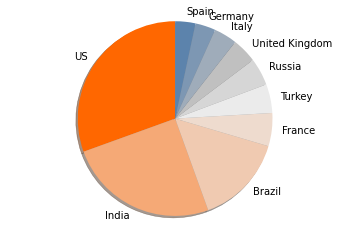

In [34]:
fig1, ax1 = plt.subplots()
colors = ["#FF6700","#F5A976","#F0CAB1","#EEDBCE","#EBEBEB", "#D6D6D6", "#C0C0C0", "#9FACBA", "#7D97B3","#5C83AC"]
ax1.pie(covid_cases_top_10['Confirmed_Cases'], labels=covid_cases_top_10['Country/Region'],
        shadow=True, startangle=90,colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [35]:
# function to create pie charts
def donut(i,sizes,title,colors, pos, pct=None):
    plt.subplot(i)
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
                shadow=True, startangle=90, autopct= pct, pctdistance=0.9)

    centre_circle = plt.Circle((0,0),0.6,color='black', fc='white',linewidth=1.5)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    fig.gca().annotate(title, xy=(pos, 0), fontsize=15)
    #plt.title(title)
    plt.axis('equal')

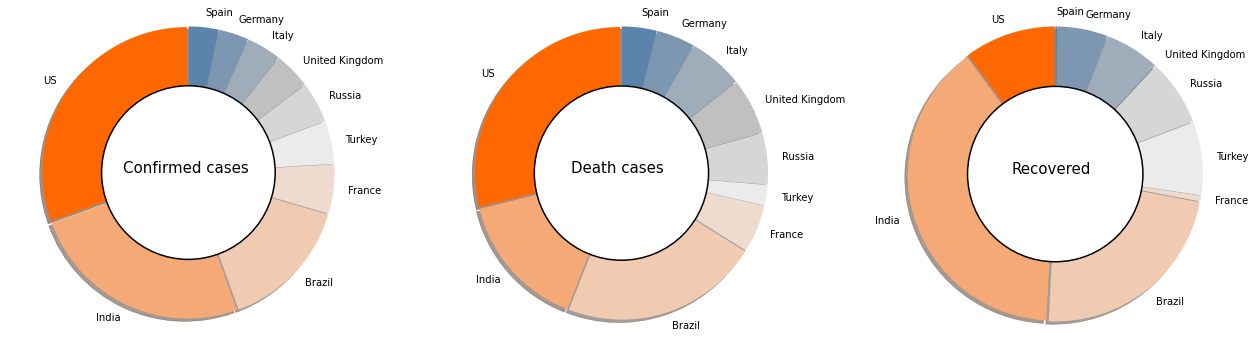

In [36]:
fig = plt.subplots(figsize=(22, 6))
labels = covid_cases_top_10['Country/Region'].to_list()
confirmed = covid_cases_top_10['Confirmed_Cases'].to_list()
deaths = covid_cases_top_10['Deaths'].to_list()
recovered = covid_cases_top_10['Recovered'].to_list()
colors = ["#FF6700","#F5A976","#F0CAB1","#EEDBCE","#EBEBEB", "#D6D6D6", "#C0C0C0", "#9FACBA", "#7D97B3","#5C83AC"]

# some other palette
#confirmed_colors = ["#FF6700","#F5A976","#F0CAB1","#EEDBCE","#EBEBEB", "#D6D6D6", "#C0C0C0", "#9FACBA", "#7D97B3","#5C83AC"]
#deaths_colors = ["#03071E","#370617","#6A040F","#9D0208","#D00000", "#DC2F02", "#E85D04", "#F48C06", "#FAA307","#FFBA08"]
#recovered_colors = ["#D9ED92","#76C893","#52B69A", "#34A0A4", "#168AAD", "#1A759F", "#1E6091","#2D5E83","#406D8E","#517A98"]
explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01) 

donut(131,confirmed,'Confirmed cases',colors,-0.45)
donut(132,deaths,'Death cases',colors,-0.35)
donut(133,recovered,'Recovered',colors,-0.3)
plt.show()

In [37]:
covid_cases_top_10['Hospitalized'] = covid_cases_top_10['Confirmed_Cases']-covid_cases_top_10['Deaths']-covid_cases_top_10['Recovered']
covid_cases_top_10

Country/Region  Confirmed_Cases  Deaths  Recovered  Hospitalized
0              US         33166418  590941    6298082      26277395
1           India         27157795  311388   24350816       2495591
2          Brazil         16194209  452031   14231991       1510187
3          France          5978650  109040     386798       5482812
4          Turkey          5203385   46621    5045508        111256
5          Russia          4960174  117197    4579421        263556
6  United Kingdom          4483177  128001      15453       4339723
7           Italy          4197892  125501    3804246        268145
8         Germany          3662568   87733    3439570        135265
9           Spain          3652879   79801     150376       3422702

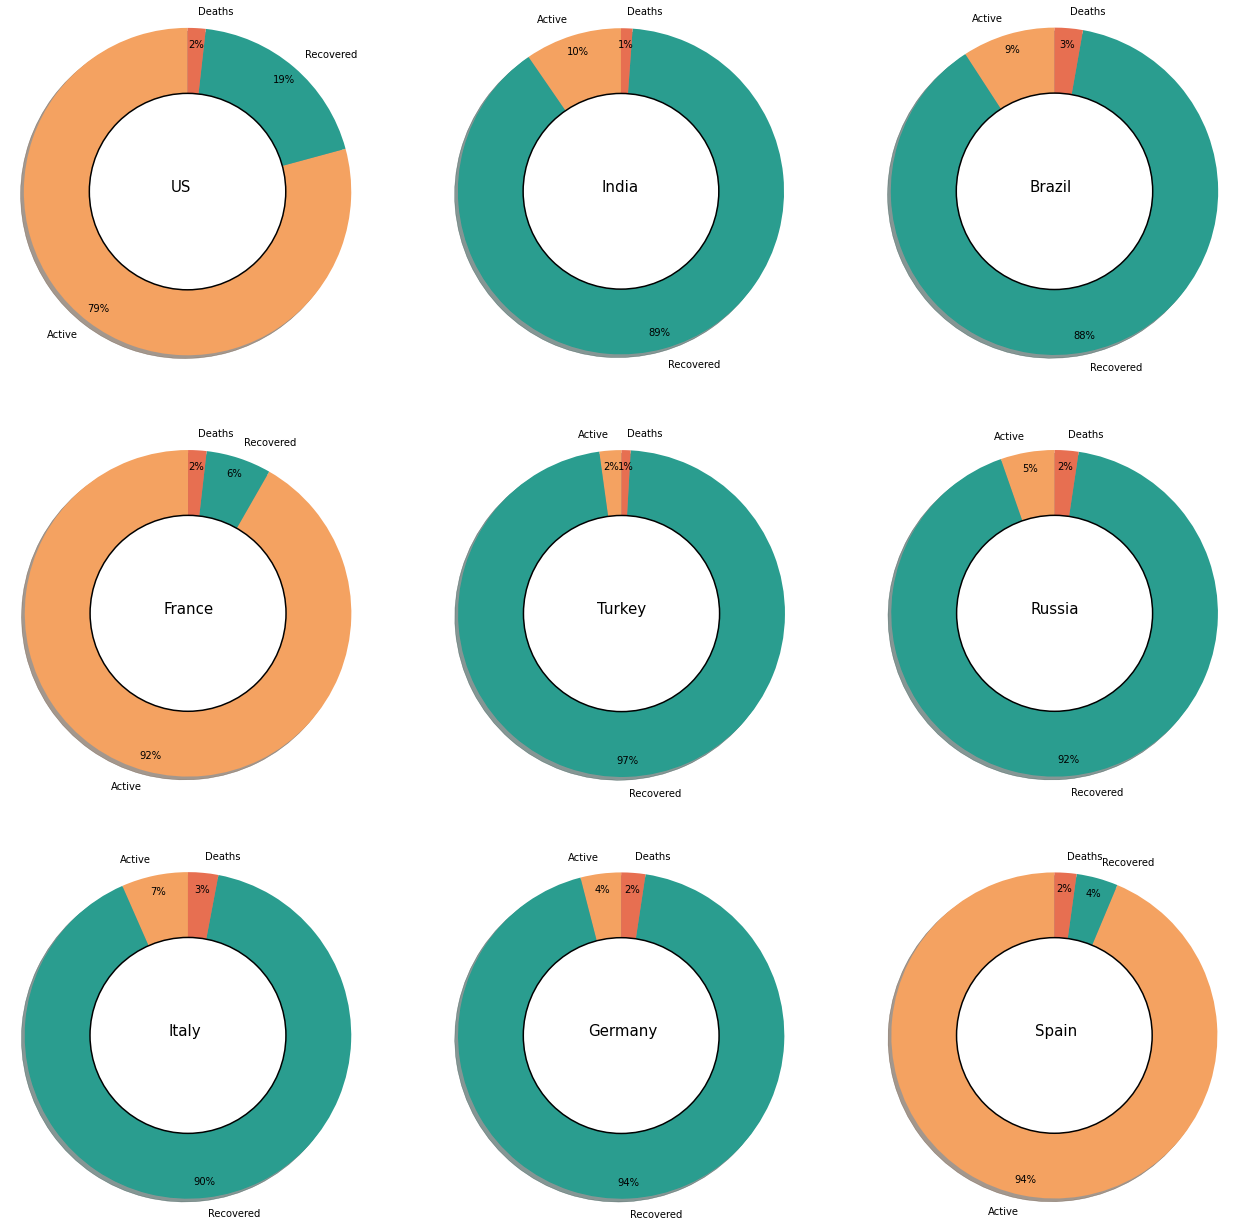

In [38]:
explode = (0.0, 0.0, 0.0) 

fig = plt.subplots(figsize=(22, 22))
labels = ['Active', 'Recovered', 'Deaths']
us = ['26255047', '6298082', '590533']
india = ['2586782', '24054861', '307231']
brazil = ['1480254', '14190644', '449858']
france = ['5483870', '385961', '108819']
turkey = ['113248', '5034316', '46446']
russia = ['264758', '4570842', '116812']
italy = ['276439', '3792898', '125335']
germany = ['147149', '3425380', '87461']
spain = ['3417433', '150376', '79711']

colors = ["#F4A261","#2A9D8F","#E76F51"]

donut(331,us,'US',colors,-0.1, pct='%.0f%%')
donut(332,india,'India',colors,-0.12, pct='%.0f%%')
donut(333,brazil,'Brazil',colors,-0.15, pct='%.0f%%')
donut(334,france,'France',colors,-0.15, pct='%.0f%%')
donut(335,turkey,'Turkey',colors,-0.15, pct='%.0f%%')
donut(336,russia,'Russia',colors,-0.15, pct='%.0f%%')
donut(337,italy,'Italy',colors,-0.12, pct='%.0f%%')
donut(338,germany,'Germany',colors,-0.20, pct='%.0f%%')
donut(339,spain,'Spain',colors,-0.12, pct='%.0f%%')
plt.show()

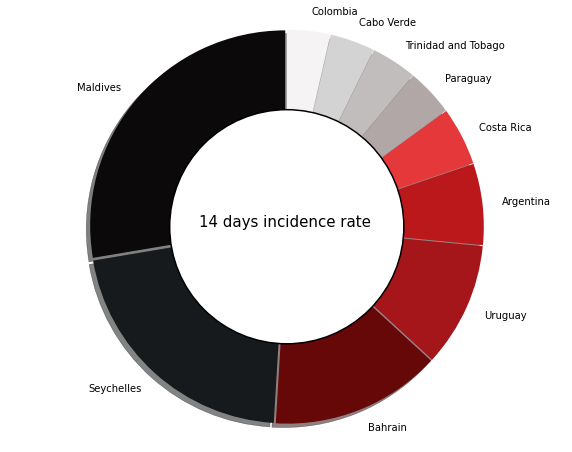

In [39]:
incidence_rate = cases_incidence.sort_values(by='14-day-incidence-rate', ascending=False).reset_index().head(n=10)

# pie chart
fig = plt.subplots(figsize=(10, 8))
labels = incidence_rate['Country'].to_list()
incidence_rate = incidence_rate['14-day-incidence-rate'].to_list()
colors = ["#0B090A","#161A1D","#660708","#A4161A","#BA181B", "#E5383B", "#B1A7A6", "#C2BDBD", "#D3D3D3","#F5F3F4"]

explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01) 

donut(111,incidence_rate,'14 days incidence rate',colors,-0.45)

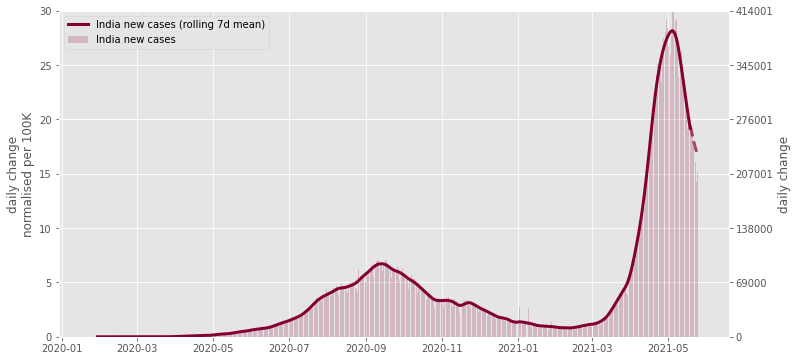

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
cases, deaths = ov.get_country_data("India") 
ov.plot_daily_change(ax=ax, series=cases, color="#840032", 
                     labels=("India", "cases"));

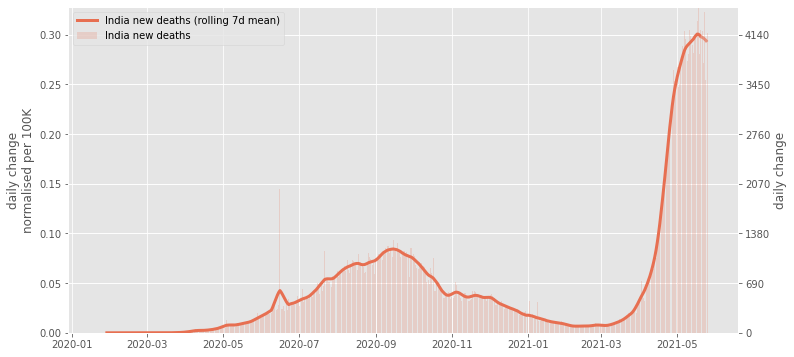

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
ov.plot_daily_change(ax=ax, series=deaths, color="#E76F51", 
                     labels=("India", "deaths"));

In [42]:
cases_incidence

14-day-sum  population  14-day-incidence-rate
Country                                                          
Afghanistan               4185    38928341                   10.8
Albania                    384     2877800                   13.3
Algeria                   2679    43851043                    6.1
Andorra                    194       77265                  251.1
Angola                    3528    32866268                   10.7
...                        ...         ...                    ...
Vietnam                   2273    97338583                    2.3
West Bank and Gaza        3064     5101416                   60.1
Yemen                      172    29825968                    0.6
Zambia                    1217    18383956                    6.6
Zimbabwe                   240    14862927                    1.6

[192 rows x 3 columns]

In [43]:


day_incidence = cases_incidence['14-day-incidence-rate'].tolist()

country_list = cases_incidence.index.tolist()
#country_set = set(country_list)
#country_list = list(country_set)
#country_list.sort()

new_df = pd.DataFrame(list(zip(country_list, day_incidence)), 
               columns =['Country', 'Incidence'])

new_df = new_df[(new_df['Incidence']>0.1) & (new_df['Incidence'] < 1200)].sort_values(by='Incidence', ascending=True)
#colors = ["#F9F9F5", "#FAFAE6", "#FCFCCB", "#FCFCAE",  "#FCF1AE", "#FCEA7D", "#FCD97D",
#          "#FCCE7D", "#FCC07D", "#FEB562", "#F9A648",  "#F98E48", "#FD8739", "#FE7519",
#          "#FE5E19", "#FA520A", "#FA2B0A", "#9B1803",  "#861604", "#651104", "#570303",]


fig = go.Figure(data=go.Choropleth(
    locationmode = "country names",
    locations = new_df['Country'],
    z = new_df['Incidence'],
    text = new_df['Incidence'],
    #colorscale = colors,
    autocolorscale=True,
    reversescale=False,
    colorbar_title = '14 days incidence rate',
))

fig.update_layout(
    title_text='14 days incidence rate',
    geo=dict(
        showcoastlines=False,
    ),
)

In [44]:
population = cases_incidence['population'].tolist()

country_list = cases_incidence.index.tolist()

new_df = pd.DataFrame(list(zip(country_list, population)), 
               columns =['Country', 'Population'])

#new_df = new_df[(new_df['Incidence']>0.1) & (new_df['Incidence'] < 600)].sort_values(by='Incidence', ascending=True)
colors = ["#780000","#c1121f","#ab2531","#953843","#804a54","#6a5d66","#547078","#2a5060","#003049","#669bbc"]


fig = go.Figure(data=go.Choropleth(
    locationmode = "country names",
    locations = new_df['Country'],
    z = new_df['Population'],
    text = new_df['Population'],
    colorscale=colors,
    #autocolorscale=True,
    reversescale=True,
    colorbar_title = 'Population',
))

fig.update_layout(
    title_text='Population',
    geo=dict(
        showcoastlines=False,
    ),
)

In [45]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_global_merged.index, y=df_global_merged["Confirmed_Cases"],
                    mode='markers',
                    name='Confirmed',marker_color="#840032"))
fig.add_trace(go.Scatter(x=df_global_merged.index, y=df_global_merged["Recovered"],
                    mode='markers',
                    name='Recovered', marker_color="#2A9D8F"))
fig.add_trace(go.Scatter(x=df_global_merged.index, y=df_global_merged["Deaths"],
                    mode='markers',
                    name='Death', marker_color="#E76F51"))
fig.update_layout(title="Confirmed, Recovered, Death case counts",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.update_yaxes(type="log")
fig.show()

In [46]:
df_india_daily = df_countries_daily[df_countries_daily['Country/Region'] == 'India']

In [47]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_india_daily.Date, y=df_india_daily["Confirmed_Cases"],
                    mode='markers',
                    name='Confirmed',marker_color="#840032"))
fig.add_trace(go.Scatter(x=df_india_daily.Date, y=df_india_daily["Recovered"],
                    mode='markers',
                    name='Recovered', marker_color="#2A9D8F"))
fig.add_trace(go.Scatter(x=df_india_daily.Date, y=df_india_daily["Deaths"],
                    mode='markers',
                    name='Death', marker_color="#E76F51"))
fig.update_layout(title="Confirmed, Recovered, Death case counts",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.update_yaxes(type="log")
fig.show()

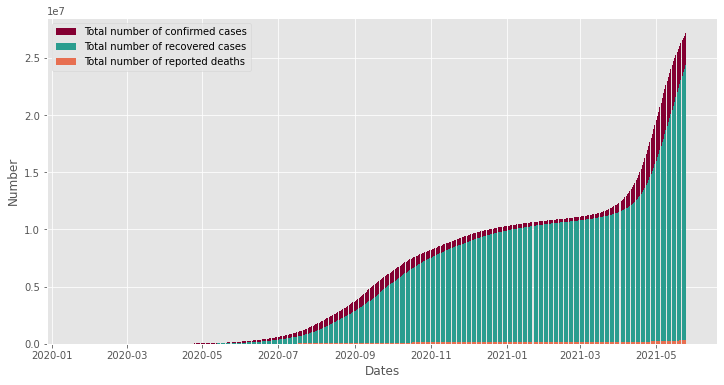

In [48]:
df_india_daily = df_countries_daily[df_countries_daily['Country/Region'] == 'India']

plt.figure(figsize=(12,6))
plt.bar(df_india_daily.Date, df_india_daily.Confirmed_Cases, color='#840032', label="Total number of confirmed cases")
plt.bar(df_india_daily.Date, df_india_daily.Recovered, color='#2A9D8F',label="Total number of recovered cases")
plt.bar(df_india_daily.Date, df_india_daily.Deaths, color='#E76F51',label="Total number of reported deaths")
plt.xlabel("Dates")
plt.ylabel("Number")
plt.legend()
plt.show()

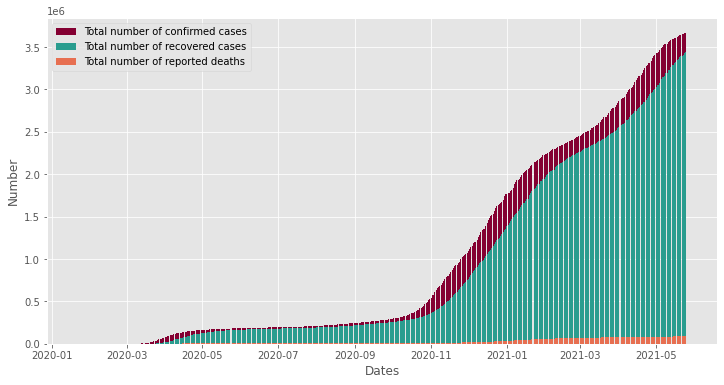

In [49]:
df_ger_daily = df_countries_daily[df_countries_daily['Country/Region'] == 'Germany']

plt.figure(figsize=(12,6))
plt.bar(df_ger_daily.Date, df_ger_daily.Confirmed_Cases, color='#840032', label="Total number of confirmed cases")
plt.bar(df_ger_daily.Date, df_ger_daily.Recovered, color='#2A9D8F',label="Total number of recovered cases")
plt.bar(df_ger_daily.Date, df_ger_daily.Deaths, color='#E76F51',label="Total number of reported deaths")
plt.xlabel("Dates")
plt.ylabel("Number")
plt.legend()
plt.show()



In [50]:
tree_color = ["#0d1321","#1d2d44","#3e5c76","#46637e","#4d6a85","#55718d","#5d7794","#657e9c",
              "#6c85a3","#6d86a4","#6e87a5","#6f87a6","#7088a7","#7089a7","#718aa8","#728aa9","#738baa","#748cab",
              "#8196b3","#8da1ba","#9aabc2","#a7b6ca","#b3c0d1","#c0cbd9","#ccd5e0","#d9e0e8","#dce3ea","#e0e6ec"]
fig = px.treemap(covid_cases.head(n=25), path=["Country/Region"], values="Confirmed_Cases", title='Confirmed Cases', color_discrete_sequence = tree_color)
fig.show()

In [178]:
fig = px.treemap(covid_cases.head(n=25), path=["Country/Region"], values="Deaths", title='Deaths', color_discrete_sequence = tree_color)
fig.show()

In [52]:
folium_map = folium.Map(location=[33.886917, 9.537499], zoom_start=2, tiles='Stamen Toner',control_scale=True)
color="yellow"

most_recent_date = df_combined['Date'].max()
df_latest_day = df_combined[df_combined.Date==most_recent_date]

for place in df_latest_day.index:
    lat = df_latest_day.loc[place]["Lat"]
    lng = df_latest_day.loc[place]["Long"]    
    confirmed = df_latest_day.loc[place]["Confirmed_Cases"]
    deaths = df_latest_day.loc[place]["Deaths"]
   
    # draw a circle on the province / state / region / country
    #marker_confirmed = folium.CircleMarker(location=[lat, lng],radius=confirmed/scale,color="#F4A261",fill=True)
    #marker_confirmed.add_to(folium_map)
    
    marker_deaths = folium.CircleMarker(location=[lat, lng],radius=deaths/5000,color="#ee6352",fill=True,)
    marker_deaths.add_to(folium_map)
    
display(folium_map)

In [53]:
folium_map = folium.Map(location=[33.886917, 9.537499], zoom_start=2, tiles='Stamen Toner',control_scale=True)
color="yellow"

most_recent_date = df_combined['Date'].max()
df_latest_day = df_combined[df_combined.Date==most_recent_date]

for place in df_latest_day.index:
    lat = df_latest_day.loc[place]["Lat"]
    lng = df_latest_day.loc[place]["Long"]    
    confirmed = df_latest_day.loc[place]["Confirmed_Cases"]
    deaths = df_latest_day.loc[place]["Deaths"]
   
    # draw a circle on the province / state / region / country
    marker_confirmed = folium.CircleMarker(location=[lat, lng],radius=confirmed/400000,color="#840032",fill=True)
    marker_confirmed.add_to(folium_map)
    
display(folium_map)

In [54]:
fig = px.bar(df_countries_daily[df_countries_daily['Country/Region'].isin(['US', 'India', 'Brazil'])], x="Date", y="Confirmed_Cases", color='Country/Region',
             title='Number of confirmed cases')
fig.update_xaxes(tickangle=-0)
fig.show()

In [55]:
fig = px.bar(df_countries_daily[df_countries_daily['Country/Region'].isin(['US', 'India', 'Brazil'])], x="Date", y="Deaths", color='Country/Region',
             title='Number of deaths')
fig.update_xaxes(tickangle=-0)
fig.show()

In [56]:
fig = px.line(df_countries_daily[df_countries_daily['Country/Region'].isin(['US', 'India', 'Brazil','France','Turkey','Russia'])], x="Date", y="Confirmed_Cases", color='Country/Region',
             title='Number of confirmed cases')
fig.update_layout(hovermode='closest',template='seaborn',width=700,xaxis=dict(mirror=True,linewidth=3,linecolor='black',showgrid=True),
                 yaxis=dict(mirror=True,linewidth=2,linecolor='black'))
fig.show()

In [57]:
df_us_daily = df_countries_daily[df_countries_daily['Country/Region'] == 'US']
df_brazil_daily = df_countries_daily[df_countries_daily['Country/Region'] == 'Brazil']

fig = go.Figure(data=[
    go.Bar(name='US', x=df_us_daily['Date'], y=df_us_daily['Confirmed_Cases']),
    go.Bar(name='India', x=df_india_daily['Date'], y=df_india_daily['Confirmed_Cases']),
    go.Bar(name='Brazil', x=df_brazil_daily['Date'], y=df_brazil_daily['Confirmed_Cases'])
])
# Change the bar mode
fig.update_layout(barmode='overlay', title='Confirmed cases',
                 annotations=[dict(x='2020-03-09', y=1797, xref="x", yref="y", text="Lockdown<br>Imposed<br>(9th March)", showarrow=True, arrowhead=1, ax=-50, ay=-50)])
fig.update_layout(hovermode='closest',template='seaborn',width=700,xaxis=dict(mirror=True,linewidth=2,linecolor='black',showgrid=False),
                 yaxis=dict(mirror=True,linewidth=2,linecolor='black'))
fig.show()

In [58]:
covid_cases

Country/Region  Confirmed_Cases  Deaths  Recovered
0                  US         33166418  590941    6298082
1               India         27157795  311388   24350816
2              Brazil         16194209  452031   14231991
3              France          5978650  109040     386798
4              Turkey          5203385   46621    5045508
..                ...              ...     ...        ...
187        MS Zaandam                9       2          7
188           Vanuatu                4       1          3
189  Marshall Islands                4       0          4
190             Samoa                3       0          3
191        Micronesia                1       0          1

[192 rows x 4 columns]

In [59]:
#Interactive scatter plot ===> Confirmed cases at diff country levels
fig4 = px.scatter(covid_cases.sort_values('Confirmed_Cases',ascending=False).head(30),x='Confirmed_Cases',y='Recovered',color='Country/Region'
                  ,size='Confirmed_Cases')
fig4.update_traces(textposition='top center')
#fig4.update_layout(xaxis_rangeslider_visible=True)
fig4.show()

In [60]:
#Interactive scatter plot ===> Confirmed cases at diff country levels
fig4 = px.scatter(covid_cases.sort_values('Confirmed_Cases',ascending=False).head(30),x='Confirmed_Cases',y='Deaths',color='Country/Region'
                  ,size='Confirmed_Cases')
fig4.update_traces(textposition='top center')
#fig4.update_layout(xaxis_rangeslider_visible=True)
fig4.show()

In [61]:
fig = px.bar(covid_cases.sort_values("Confirmed_Cases",ascending=False).head(10), x = "Country/Region", y = "Confirmed_Cases",text="Confirmed_Cases", color='Confirmed_Cases')
fig.show()

In [62]:
confirmed_cases = covid_cases['Confirmed_Cases'].sum()
deaths_cases = covid_cases['Deaths'].sum()
recoverd_cases = covid_cases['Recovered'].sum()
active_cases = confirmed_cases-deaths_cases-recoverd_cases

In [63]:
fig = go.Figure()
fig.add_trace(go.Indicator(mode="number",value=int(confirmed_cases),number={"valueformat":"0.f"},
             title={"text":"Total_Confirmed"},domain={"row":0,"column":0}))

fig.add_trace(go.Indicator(mode="number",value=int(deaths_cases),number={"valueformat":"0.f"},
             title={"text":"Total_Deaths"},domain={"row":0,"column":1}))

fig.add_trace(go.Indicator(mode="number",value=int(recoverd_cases),number={"valueformat":"0.f"},
             title={"text":"Total_Recovered"},domain={"row":1,"column":0}))

fig.add_trace(go.Indicator(mode="number",value=int(active_cases),number={"valueformat":"0.f"},
             title={"text":"Total_Active_Case"},domain={"row":1,"column":1}))

fig.update_layout(grid={"rows":2,"columns":2,"pattern":"independent"})
fig.show()

In [64]:
df_countries_daily.sort_values('Confirmed_Cases',ascending=False).head(20)

Date Country/Region  Confirmed_Cases  ...  Year  Month          Code
94066 2021-05-25             US         33166418  ...  2021      5  Unknown code
93874 2021-05-24             US         33143662  ...  2021      5  Unknown code
93682 2021-05-23             US         33117737  ...  2021      5  Unknown code
93490 2021-05-22             US         33104884  ...  2021      5  Unknown code
93298 2021-05-21             US         33085106  ...  2021      5  Unknown code
93106 2021-05-20             US         33056765  ...  2021      5  Unknown code
92914 2021-05-19             US         33026624  ...  2021      5  Unknown code
92722 2021-05-18             US         32997331  ...  2021      5  Unknown code
92530 2021-05-17             US         32969512  ...  2021      5  Unknown code
92338 2021-05-16             US         32940846  ...  2021      5  Unknown code
92146 2021-05-15             US         32923982  ...  2021      5  Unknown code
91954 2021-05-14             US         32895169  ...  2021      5  Unknown code
91762 2021-05-13             US         32852871  ...  2021      5  Unknown code
91570 2021-05-12             US         32814784  ...  2021      5  Unknown code
91378 2021-05-11             US         32778906  ...  2021      5  Unknown code
91186 2021-05-10             US         32745255  ...  2021      5  Unknown code
90994 2021-05-09             US         32708357  ...  2021      5  Unknown code
90802 2021-05-08             US         32686965  ...  2021      5  Unknown code
90610 2021-05-07             US         32652472  ...  2021      5  Unknown code
90418 2021-05-06             US         32605183  ...  2021      5  Unknown code

[20 rows x 8 columns]

In [65]:
df_vaccine_data

location       date  daily_vaccinations
0      Afghanistan 2021-02-22                 0.0
1      Afghanistan 2021-02-23              1367.0
2      Afghanistan 2021-02-24              1367.0
3      Afghanistan 2021-02-25              1367.0
4      Afghanistan 2021-02-26              1367.0
...            ...        ...                 ...
22092     Zimbabwe 2021-05-20             16482.0
22093     Zimbabwe 2021-05-21             16098.0
22094     Zimbabwe 2021-05-22             15823.0
22095     Zimbabwe 2021-05-23             16298.0
22096     Zimbabwe 2021-05-24             14380.0

[22097 rows x 3 columns]

In [66]:
df_us_vaccine_daily = df_vaccine_data[df_vaccine_data['location'] == 'United States']
df_brazil_vaccine_daily = df_vaccine_data[df_vaccine_data['location'] == 'Brazil']
df_india_vaccine_daily = df_vaccine_data[df_vaccine_data['location'] == 'India']

fig = go.Figure(data=[
    go.Bar(name='US', x=df_us_vaccine_daily['date'], y=df_us_vaccine_daily['daily_vaccinations']),
    go.Bar(name='India', x=df_india_vaccine_daily['date'], y=df_india_vaccine_daily['daily_vaccinations']),
    go.Bar(name='Brazil', x=df_brazil_vaccine_daily['date'], y=df_brazil_vaccine_daily['daily_vaccinations'])
])
# Change the bar mode
fig.update_layout(barmode='overlay', title='Vaccination',
                 annotations=[dict(x='2020-03-09', y=1797, xref="x", yref="y", text="Lockdown<br>Imposed<br>(9th March)", showarrow=True, arrowhead=1, ax=-50, ay=-50)])
fig.update_layout(hovermode='closest',template='seaborn',width=700,xaxis=dict(mirror=True,linewidth=2,linecolor='black',showgrid=False),
                 yaxis=dict(mirror=True,linewidth=2,linecolor='black'))
fig.show()

In [67]:
df_vaccine_data['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei',
       'Bulgaria', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'England',
       'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia', 'Europe',
       'European Union', 'Faeroe Islands', 'Falkland Islands', 'Fiji',
   

In [71]:
total_vaccination = pd.DataFrame(df_vaccine_data[~df_vaccine_data['location'].isin(['World', 'Asia', 'Upper middle income','High income','North America','Europe','Lower middle income','European Union','South America'])][['location',	'daily_vaccinations']].groupby(['location']).sum()).sort_values("daily_vaccinations",ascending=False).reset_index()

In [72]:
fig = px.bar(total_vaccination.head(10), x = "location", y = "daily_vaccinations",text="daily_vaccinations", color='daily_vaccinations')
fig.show()

In [226]:
data_df = cases_incidence.sort_values(by='14-day-incidence-rate', ascending=False).reset_index().reset_index()
data_pop_df = cases_incidence.sort_values(by='population', ascending=False).reset_index().reset_index()

# create tuples fpr wordcloud
total_tupels = [tuple(x) for x in total_vaccination.values]
confirmed_tupels = [tuple(x) for x in covid_cases[['Country/Region','Confirmed_Cases']].values]
deaths_tupels = [tuple(x) for x in covid_cases[['Country/Region','Deaths']].values]
recovered_tupels = [tuple(x) for x in covid_cases[['Country/Region','Recovered']].values]
population_tupels = [tuple(x) for x in data_pop_df[['Country','population']].values]
incidencerate_tupels = [tuple(x) for x in data_df[['Country','14-day-incidence-rate']].values]

#colormap
color = 'afmhot'

#mask
mask = np.array(Image.open("/content/Goethe.png"))

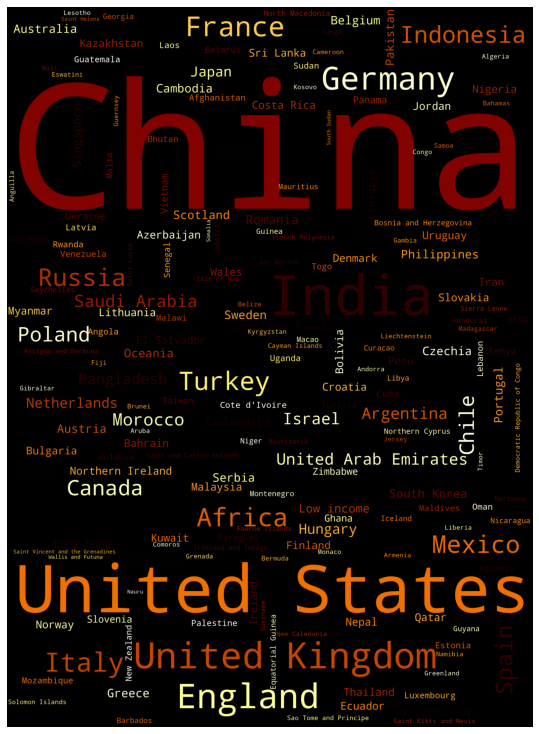

In [227]:
wc = WordCloud(background_color='black', colormap=color,collocations=False,random_state=1, 
 mask = mask,scale=6, relative_scaling ='auto',max_font_size=400).generate_from_frequencies(dict(total_tupels))
plt.figure(figsize = [15,10])
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

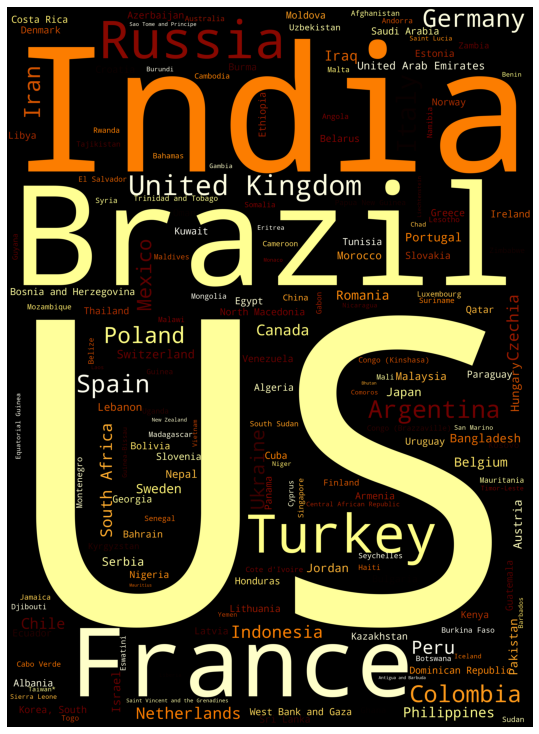

In [228]:
wc = WordCloud(background_color='black', colormap=color,collocations=False,random_state=1, 
 mask = mask,scale=6, relative_scaling ='auto',max_font_size=400).generate_from_frequencies(dict(confirmed_tupels))
plt.figure(figsize = [15,10])
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

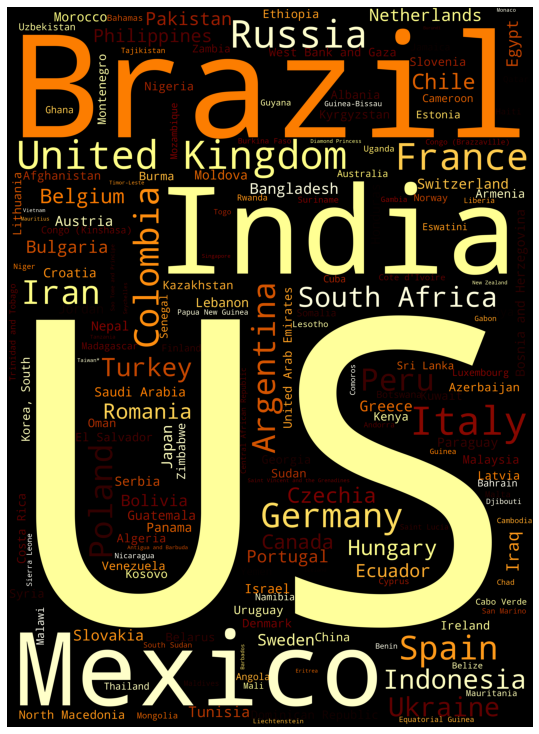

In [300]:
wc = WordCloud(background_color='black', colormap=color,collocations=False,random_state=1, 
 mask = mask,scale=6, relative_scaling ='auto',max_font_size=400).generate_from_frequencies(dict(deaths_tupels))
plt.figure(figsize = [15,10])
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

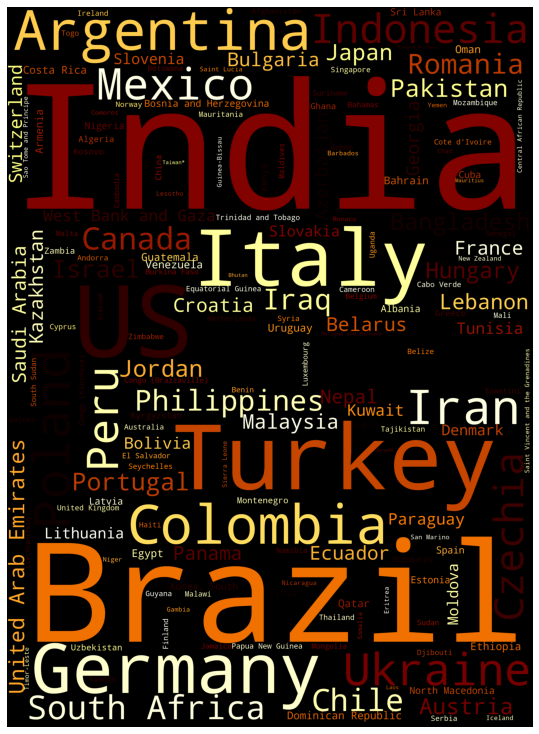

In [230]:
wc = WordCloud(background_color='black', colormap=color,collocations=False,random_state=1, 
 mask = mask,scale=6, relative_scaling ='auto',max_font_size=400).generate_from_frequencies(dict(recovered_tupels))
plt.figure(figsize = [15,10])
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

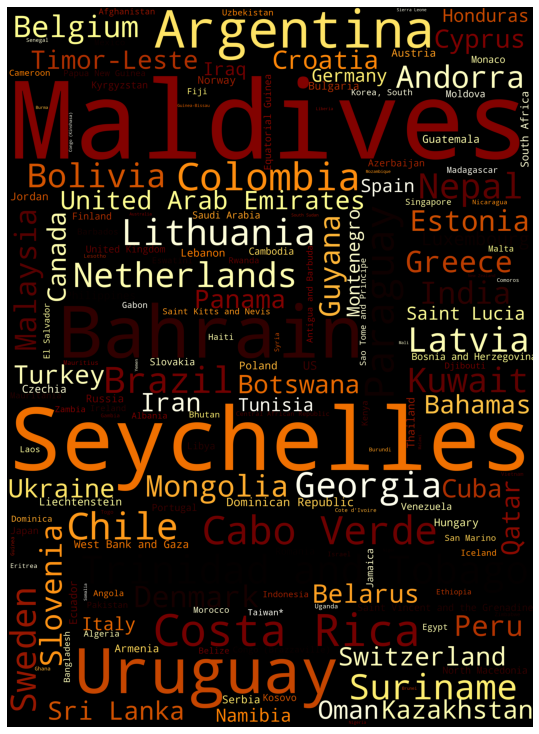

In [231]:
wc = WordCloud(background_color='black', colormap=color,collocations=False,random_state=1, 
 mask = mask,scale=6, relative_scaling ='auto',max_font_size=400).generate_from_frequencies(dict(incidencerate_tupels))
plt.figure(figsize = [15,10])
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

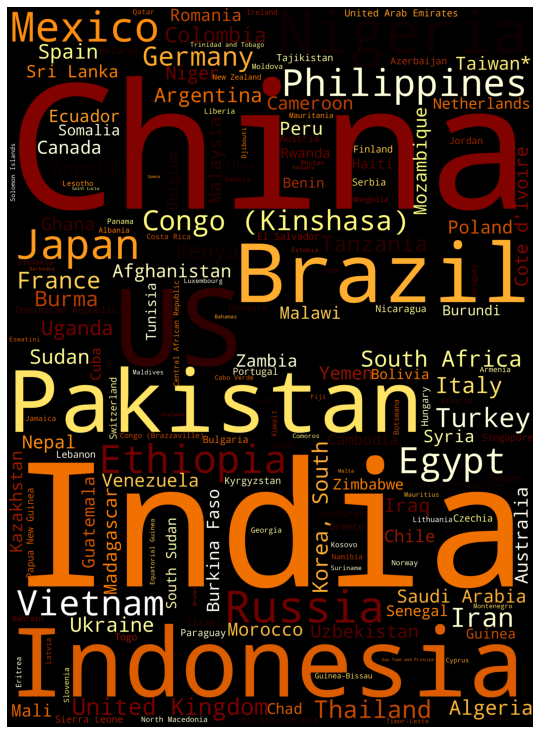

In [232]:
wc = WordCloud(background_color='black', colormap=color,collocations=False,random_state=1, 
 mask = mask,scale=6, relative_scaling ='auto',max_font_size=400).generate_from_frequencies(dict(population_tupels))
plt.figure(figsize = [15,10])
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [233]:
# country to continent
covid_cases

Country/Region  Confirmed_Cases  Deaths  Recovered
0                  US         33166418  590941    6298082
1               India         27157795  311388   24350816
2              Brazil         16194209  452031   14231991
3              France          5978650  109040     386798
4              Turkey          5203385   46621    5045508
..                ...              ...     ...        ...
187        MS Zaandam                9       2          7
188           Vanuatu                4       1          3
189  Marshall Islands                4       0          4
190             Samoa                3       0          3
191        Micronesia                1       0          1

[192 rows x 4 columns]

In [301]:
#create df
df_continent = covid_cases[~covid_cases['Country/Region'].isin(['West Bank and Gaza','Burma','Korea, South','Kosovo',"Cote d'Ivoire",'Congo (Kinshasa)','Congo (Brazzaville)','Zimbabwe','Timor-Leste','Taiwan*'])].sort_values(by='Confirmed_Cases', ascending=False).head(n=165)
df_continent["Country/Region"].replace({"US": "United States"}, inplace=True)
# create continent name
input_countries = df_continent['Country/Region']

continent = [pc.convert_continent_code_to_continent_name(pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country, cn_name_format="default"))) for country in input_countries]

df_continent['Continent'] = continent

In [307]:
# customize the labels 
fig = px.scatter(df_continent, x='Confirmed_Cases', y='Deaths', color='Continent', size='Confirmed_Cases', size_max=60, 
                hover_name='Country/Region',log_x=True, log_y=True,color_discrete_sequence=["#cc9900","#fb5607","#ff006e","#8338ec","#1d4b94","#000814"],
                )
fig.show()